# Prediction of the Prices of Toyota Corolla

**Business case:** the CEO from Toyota Barcelona has contacted us because she is interested in having a model to predict the prices of the different Corolla models that she is selling. 

    Right now, they have developed and algorithm that has an error of 50%, so they are not feeling really confident with their results. She has contacted us because she is interested in having a model with better Accuracy. Can you help her?

## **1. Overview**

Columns:
- <b> Age: </b> Age in months
- <b> KM: </b> Accumulated Kilometers on odometer
- <b> FuelType: </b> Fuel Type (Petrol, Diesel, CNG)
- <b> HP: </b> Horse Power
- <b> MetColor: </b> Metallic Color? (Yes=1, No=0)
- <b> Automatic: </b> Automatic ( (Yes=1, No=0)
- <b> CC: </b> Cylinder Volume in cubic centimeters
- <b> Doors: </b> Number of doors
- <b> Weight: </b> Weight in Kilograms
- <b> Price: </b> Offer Price in EUROs

##  **2. Importing Libraries and Reading the Dataset**

In [1]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math 

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, ElasticNet, LassoCV
from sklearn.ensemble import RandomForestRegressor ,BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import metrics

# Modelling Helpers :
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

#preprocessing :
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler, scale

# Metrics - Regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error 

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


from collections import Counter
from IPython.core.display import display, HTML
sns.set_style('darkgrid')

In [2]:
dataset = pd.read_csv('../datasets/ToyotaCorolla.csv')
dataset.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


In [3]:
dataset.shape

(1436, 10)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


In [5]:
dataset.FuelType.value_counts()

Petrol    1264
Diesel     155
CNG         17
Name: FuelType, dtype: int64

In [6]:
data = dataset.copy()

In [7]:
data_fuel_type_onehot = pd.get_dummies(data['FuelType'], 
                                       columns=['FuelType'],
                                       prefix = ['FuelType'])
data_fuel_type_onehot.head()

,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [8]:
data.drop(columns='FuelType', inplace=True)

In [9]:
print("Range: ", data['Price'].describe())

Range:  count     1436.000000
mean     10730.824513
std       3626.964585
min       4350.000000
25%       8450.000000
50%       9900.000000
75%      11950.000000
max      32500.000000
Name: Price, dtype: float64


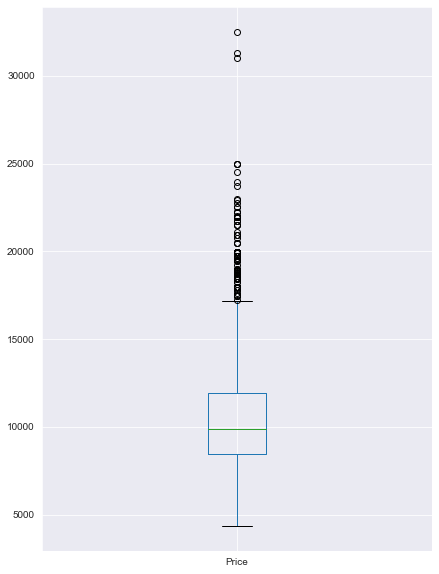

In [10]:
fig = plt.figure(figsize=(7,10))
data.boxplot(column=['Price'])
plt.show()

In [11]:
data[data.Price > 23000].sort_values(ascending=False, by='Price')

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
109,32500,4,1,116,0,0,2000,5,1480
111,31275,4,1500,116,1,0,2000,5,1480
110,31000,4,4000,116,1,0,2000,5,1480
115,24990,8,6000,90,1,0,2000,5,1280
112,24950,8,13253,116,1,0,2000,5,1320
113,24950,8,13253,116,1,0,2000,5,1320
147,24500,13,19988,110,1,0,1600,5,1130
141,23950,19,21684,192,1,0,1800,5,1185
171,23750,8,11000,110,1,0,1600,5,1130


<Figure size 504x720 with 0 Axes>

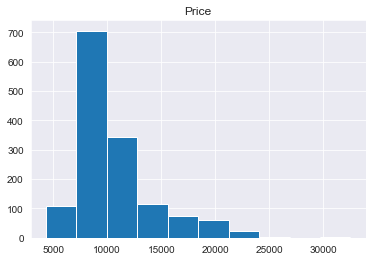

In [12]:
# Skewness?
fig = plt.figure(figsize=(7,10))
data.hist(column=['Price'])
plt.show()

In [13]:
data.corr()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
Price,1.000000,-0.876590,-0.569960,0.314990,0.108905,0.033081,0.165067,0.185326,0.581198
Age,-0.876590,1.000000,0.505672,-0.156622,-0.108150,0.031717,-0.133182,-0.148359,-0.470253
KM,-0.569960,0.505672,1.000000,-0.333538,-0.080503,-0.081854,0.302150,-0.036197,-0.028598
HP,0.314990,-0.156622,-0.333538,1.000000,0.058712,0.013144,0.050884,0.092424,0.089614
MetColor,0.108905,-0.108150,-0.080503,0.058712,1.000000,-0.019335,0.034921,0.085243,0.057929
Automatic,0.033081,0.031717,-0.081854,0.013144,-0.019335,1.000000,-0.069321,-0.027654,0.057249
CC,0.165067,-0.133182,0.302150,0.050884,0.034921,-0.069321,1.000000,0.126768,0.651450
Doors,0.185326,-0.148359,-0.036197,0.092424,0.085243,-0.027654,0.126768,1.000000,0.302618
Weight,0.581198,-0.470253,-0.028598,0.089614,0.057929,0.057249,0.651450,0.302618,1.000000


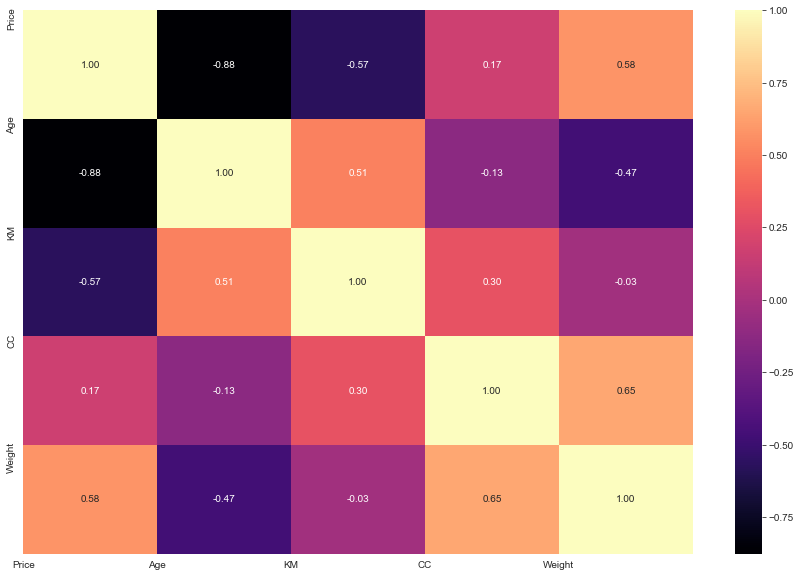

In [14]:
data2 = data[['Price', 'Age', 'KM', 'CC', 'Weight']]

corr = data2.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(15, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

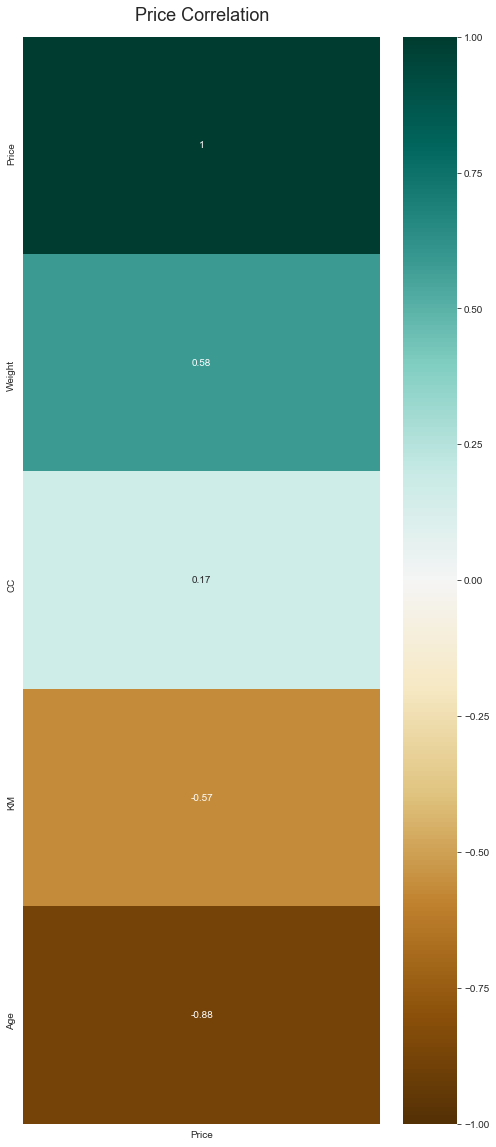

In [15]:
# Let's do a final check to see which columns have the higher correlation with the score. 
plt.figure(figsize=(8, 20))

heatmap = sns.heatmap(data2.corr()[['Price']].sort_values(by='Price', ascending=False), 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='BrBG')

heatmap.set_title('Price Correlation', fontdict={'fontsize':18}, pad=16);

In [16]:
data.head()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,90,1,0,2000,3,1165
1,13750,23,72937,90,1,0,2000,3,1165
2,13950,24,41711,90,1,0,2000,3,1165
3,14950,26,48000,90,0,0,2000,3,1165
4,13750,30,38500,90,0,0,2000,3,1170


In [17]:
data.MetColor.value_counts()

1    969
0    467
Name: MetColor, dtype: int64

In [18]:
data.Automatic.value_counts()

0    1356
1      80
Name: Automatic, dtype: int64

In [19]:
data.Doors.value_counts()

5    674
3    622
4    138
2      2
Name: Doors, dtype: int64

In [20]:
# Initialise the Scaler 
scaler = RobustScaler() 
scaler

RobustScaler()

In [21]:
# Scale data 
data2 = data[['Price', 'Age', 'KM', 'CC', 'Weight']]
dfname = data2.columns
data_Rscaled = scaler.fit_transform(data2)
data_Rscaled
data_Rscaled = pd.DataFrame(data_Rscaled, columns=dfname)

In [22]:
data_Rscaled

,Price,Age,KM,CC,Weight
0,1.028571,-1.461538,-0.372631,2.0,2.111111
1,1.100000,-1.461538,0.216886,2.0,2.111111
2,1.157143,-1.423077,-0.492461,2.0,2.111111
3,1.442857,-1.346154,-0.349596,2.0,2.111111
4,1.100000,-1.192308,-0.565404,2.0,2.222222
...,...,...,...,...,...
1431,-0.685714,0.307692,-0.973302,-1.5,-1.000000
1432,0.270000,0.423077,-1.008377,-1.5,-1.222222
1433,-0.400000,0.384615,-1.053446,-1.5,-1.222222
1434,-0.757143,0.346154,-1.055718,-1.5,-1.222222


In [23]:
doors = data[['Doors']]
doors.head()

,Doors
0,3
1,3
2,3
3,3
4,3


In [24]:
# Step 1. Instantiate the model (label encoding)
lb_make = LabelEncoder() 

# Step 2. Fit the variable to the instatiated model
doors['Doors'] = lb_make.fit_transform(doors['Doors'])

doors.head() #Results in appending a new column to df


,Doors
0,1
1,1
2,1
3,1
4,1


In [25]:
data_scaled = pd.concat([data_Rscaled, doors, data_fuel_type_onehot, data[['MetColor', 'Automatic']]], axis=1)
data_scaled.head()

,Price,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,1.028571,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,1.100000,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,1.157143,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,1.442857,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,1.100000,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0


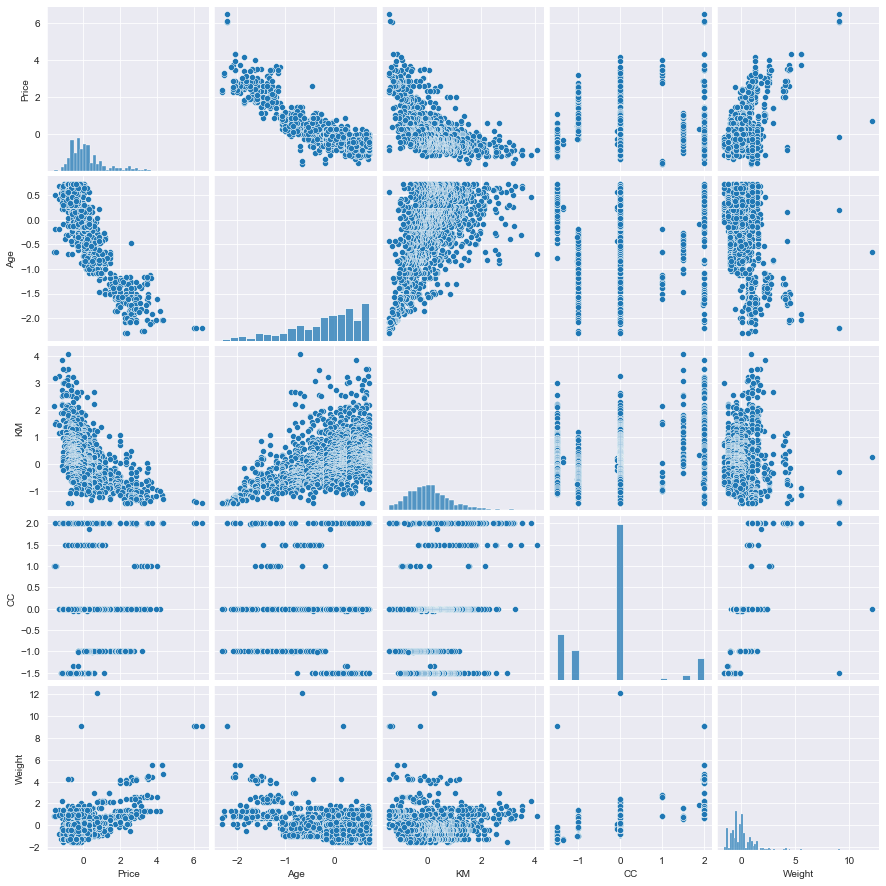

In [26]:
# Only for numerical data
sns.pairplot(data_scaled[['Price', 'Age', 'KM', 'CC', 'Weight']])

## Step 1: Identify target and non-target variables

In [27]:
data_scaled.head()

,Price,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,1.028571,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,1.100000,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,1.157143,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,1.442857,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,1.100000,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0


In [28]:
y = data_scaled['Price']

X = data_scaled['Age']

In [29]:
y

0       1.028571
1       1.100000
2       1.157143
3       1.442857
4       1.100000
          ...   
1431   -0.685714
1432    0.270000
1433   -0.400000
1434   -0.757143
1435   -0.842857
Name: Price, Length: 1436, dtype: float64

## Step 2: Split the data into train and test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33,
                                                    random_state = 7)

In [31]:
X_train

374    -0.807692
1344    0.500000
565    -0.269231
547    -0.230769
848     0.153846
          ...   
211    -0.807692
502    -0.307692
537    -0.269231
1220    0.346154
175    -2.038462
Name: Age, Length: 962, dtype: float64

In [32]:
y_train

374     0.871429
1344   -0.271429
565     0.285714
547     0.014286
848     0.014286
          ...   
211     1.385714
502     0.000000
537    -0.100000
1220   -0.571429
175     2.871429
Name: Price, Length: 962, dtype: float64

In [33]:
X_test

635     0.269231
777     0.269231
858     0.038462
71     -1.115385
1315    0.346154
          ...   
609     0.230769
603    -0.115385
1279    0.538462
379    -0.384615
1123    0.576923
Name: Age, Length: 474, dtype: float64

In [34]:
y_test

635    -0.328571
777    -0.271429
858    -0.544286
71      0.884286
1315   -0.271429
          ...   
609    -1.185429
603    -0.842857
1279   -0.685714
379    -1.000000
1123   -0.185714
Name: Price, Length: 474, dtype: float64

In [35]:
print('Shape of the raw data (X): {}'.format (X.shape))
print('Shape of the TARGET variable (y): {}'.format (y.shape))

print('\nShape of the Train data (X_train): {}'.format (X_train.shape))
print('Shape of the Train data (y_train): {}'.format (y_train.shape))

print('\nShape of the Test data (X_test): {}'.format (X_test.shape))
print('Shape of the TARGET Test data (y_test): {}'.format (y_test.shape))

Shape of the raw data (X): (1436,)
Shape of the TARGET variable (y): (1436,)

Shape of the Train data (X_train): (962,)
Shape of the Train data (y_train): (962,)

Shape of the Test data (X_test): (474,)
Shape of the TARGET Test data (y_test): (474,)


In [36]:
y_train =  np.array(y_train).reshape(-1, 1)  # values converts it into 
# a numpy array
X_train = np.array(X_train).reshape(-1, 1) 

y_test =  np.array(y_test).reshape(-1, 1)  # values converts it into a 
#numpy array
X_test = np.array(X_test).reshape(-1, 1) 

In [37]:
X_test

array([[ 0.26923077],
       [ 0.26923077],
       [ 0.03846154],
       [-1.11538462],
       [ 0.34615385],
       [ 0.26923077],
       [-0.11538462],
       [-0.15384615],
       [-0.42307692],
       [-1.        ],
       [-0.80769231],
       [ 0.26923077],
       [ 0.        ],
       [ 0.73076923],
       [-0.53846154],
       [ 0.07692308],
       [ 0.38461538],
       [ 0.07692308],
       [-1.92307692],
       [-1.69230769],
       [ 0.5       ],
       [ 0.53846154],
       [ 0.69230769],
       [ 0.61538462],
       [-1.92307692],
       [-0.03846154],
       [ 0.73076923],
       [ 0.15384615],
       [-0.73076923],
       [-0.69230769],
       [-1.57692308],
       [-0.34615385],
       [-0.73076923],
       [ 0.73076923],
       [-0.11538462],
       [-0.07692308],
       [ 0.26923077],
       [-0.46153846],
       [ 0.03846154],
       [-0.15384615],
       [-0.69230769],
       [-1.42307692],
       [-1.57692308],
       [ 0.38461538],
       [ 0.53846154],
       [ 0

## Step 3-4: Instantiate and train the model

In [38]:
# Instantiate the model
linear_m = LinearRegression()

# Train the model
linear_m.fit(X_train, y_train)

LinearRegression()

In [39]:
y_pred = linear_m.predict(X_test)
y_pred

array([[-0.34630519],
       [-0.34630519],
       [-0.05757316],
       [ 1.386087  ],
       [-0.4425492 ],
       [-0.34630519],
       [ 0.13491486],
       [ 0.18303687],
       [ 0.5198909 ],
       [ 1.24172098],
       [ 1.00111096],
       [-0.34630519],
       [-0.00945116],
       [-0.92376926],
       [ 0.66425692],
       [-0.10569517],
       [-0.49067121],
       [-0.10569517],
       [ 2.39664911],
       [ 2.10791708],
       [-0.63503722],
       [-0.68315923],
       [-0.87564725],
       [-0.77940324],
       [ 2.39664911],
       [ 0.03867085],
       [-0.92376926],
       [-0.20193918],
       [ 0.90486695],
       [ 0.85674494],
       [ 1.96355106],
       [ 0.42364689],
       [ 0.90486695],
       [-0.92376926],
       [ 0.13491486],
       [ 0.08679286],
       [-0.34630519],
       [ 0.56801291],
       [-0.05757316],
       [ 0.18303687],
       [ 0.85674494],
       [ 1.77106304],
       [ 1.96355106],
       [-0.49067121],
       [-0.68315923],
       [-0

## Step 5: Evaluate the model

In [40]:
accuracy = linear_m.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

Accuracy = 0.7376451067075935


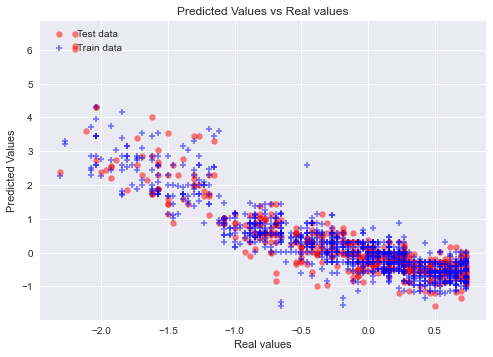

In [41]:
plt.style.use('seaborn')
plt.scatter(X_test, y_test, color = 'red', 
            marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')

plt.scatter(X_train, y_train, color = 'blue', 
            marker = '+', s = 35, alpha = 0.5,
          label = 'Train data')
#plt.plot(X_train, linear_m.predict(X_train), color = 'blue', label='Model Plot')

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')
plt.show()

### [TEST] set

In [42]:
# TEST set
MAE_l = metrics.mean_absolute_error(y_test, y_pred)
MSE_l = metrics.mean_squared_error(y_test, y_pred)
RMSE_l = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2_l = r2_score(y_test, y_pred)

print('MAE:', MAE_l)
print('MSE:', MSE_l)
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', R2_l)

MAE: 0.37174988205133425
MSE: 0.3054872545415426
RMSE: 0.553
R2 Score: 0.7376451067075935


### [TRAIN] Cross-Validation

In [43]:
from sklearn.model_selection import cross_val_score
import math

cv_reg_model = LinearRegression() #Let's initialize the method 

cv_scores = cross_val_score(cv_reg_model, X_train, y_train,
                            cv=10, scoring='r2') # Let's define the cv and 

print('Cross Validation R2_score: {}'.format(cv_scores.round(2)))

#cv_scores = np.mean(cv_scores).round(3)
#print("\nAverage 10-Fold CV R2_score: {}".format(cv_scores))

Cross Validation R2_score: [0.83 0.79 0.72 0.66 0.79 0.79 0.78 0.83 0.81 0.74]


In [44]:
# Let's calculate the metrics with our TRAIN dataset
y_predTrain = linear_m.predict(X_train)

MAE_lTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_lTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_lTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_lTrain = r2_score(y_train, y_predTrain)

print('\n TRAIN metrics\n')
print('MAE:', round(MAE_lTrain,3))
print('MSE:', round(MSE_lTrain,3))
print('RMSE:', round(RMSE_lTrain,3))
print('R2 Score:', round(R2_lTrain,3))

print('\n CV- TRAIN metrics\n')
print('R2 Score:', cv_scores)
print("\nAverage 10-Fold CV R2_score: {}".format(np.mean(cv_scores).round(3)))


print('\n TEST metrics\n')
print('MAE:', round(MAE_l,3))
print('MSE:', round(MSE_l,3))
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', round(R2_l,3))


 TRAIN metrics

MAE: 0.345
MSE: 0.221
RMSE: 0.47
R2 Score: 0.785

 CV- TRAIN metrics

R2 Score: [0.83256926 0.79295322 0.72431776 0.6649924  0.7872659  0.79242274
 0.78348248 0.83448338 0.81479442 0.74235756]

Average 10-Fold CV R2_score: 0.777

 TEST metrics

MAE: 0.372
MSE: 0.305
RMSE: 0.553
R2 Score: 0.738


## Algorithm 2. Multiple Linear Regression

In [45]:
data_scaled.head()

,Price,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,1.028571,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,1.100000,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,1.157143,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,1.442857,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,1.100000,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0


In [46]:
X = data_scaled.drop(['Price'], axis = 1)
y = data_scaled['Price']

### Split data into train and test set

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.33, 
                                                    random_state = 42)

In [48]:
X_train

,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
771,0.153846,0.333627,-1.5,-1.222222,1,0,0,1,1,0
1360,0.461538,-0.094262,0.0,-0.444444,1,0,0,1,1,0
548,-0.192308,-0.447278,-1.5,-1.000000,1,0,0,1,1,0
826,-0.115385,0.127951,-1.5,-0.777778,3,0,0,1,1,0
266,-0.653846,-0.319338,0.0,0.222222,3,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1095,0.576923,1.417252,0.0,-0.444444,1,0,0,1,0,0
1130,0.461538,0.993134,0.0,-0.444444,1,0,0,1,1,0
1294,0.730769,0.189695,0.0,0.000000,3,0,0,1,1,0
860,0.076923,0.029543,-1.5,-1.111111,1,0,0,1,0,0


## Training the Model

In [49]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [50]:
y_pred = regressor.predict(X_test)
y_pred

array([ 3.86702346e-01, -2.50370834e-01, -1.37987567e-01, -2.76919503e-01,
        2.13900359e-02, -5.52865662e-01, -3.59073220e-01, -4.64684480e-01,
        1.18837816e+00,  9.09553493e-01, -9.36734993e-02, -1.54967899e-01,
        8.58462369e-01,  8.76867047e-01, -1.46852919e-02, -3.83572628e-01,
        6.93385299e-01,  2.15868230e+00, -6.73424685e-01, -2.23834312e-01,
        7.65353317e-01,  2.27314097e+00, -5.84666036e-01,  1.50560883e-01,
       -5.99731698e-01,  1.76834957e+00,  5.21913870e-02, -6.90691989e-01,
        1.72374936e+00,  1.29114224e+00, -4.84060963e-01, -1.04993168e-01,
       -4.04630156e-01,  6.85304614e-02,  1.08574390e-01, -5.08675090e-01,
       -3.31057217e-01,  6.33550765e-03,  1.92688791e+00, -9.80077939e-02,
       -1.19432197e-02, -1.04530906e-01, -5.81303050e-01, -1.13645783e+00,
       -7.92872896e-01,  2.12447317e+00, -1.19672111e-01,  2.27135414e-01,
       -2.83499814e-01,  1.00107371e+00,  8.53247852e-01, -9.31909735e-01,
        1.53094126e+00,  

In [51]:
y_pred_train = regressor.predict(X_train)
y_pred_train

array([-4.63536620e-01, -3.69220001e-01,  7.89401444e-02, -8.33572559e-02,
        8.56720457e-01,  1.26957196e+00,  7.36398698e-01, -5.54779674e-01,
        1.77783554e+00,  2.31042556e-01,  1.54021808e-02, -6.05833073e-01,
       -9.88305385e-02, -8.12564493e-01,  4.24744081e-01, -4.52399961e-01,
       -5.55464305e-02,  9.11518479e-01, -1.57546272e-01,  6.87181090e-02,
        7.19004790e-02,  8.17468243e-01,  5.34982254e-01, -5.72219584e-01,
       -8.53963261e-01, -7.34827974e-01, -2.31242374e-01,  5.27853866e-02,
       -7.22573202e-01, -7.65146917e-01, -2.23829333e-01, -2.15141885e-01,
       -6.18749418e-01, -4.87456215e-01, -1.46201134e-01,  2.28531036e-01,
       -7.00037492e-01,  5.64320752e-01,  1.20157156e+00,  6.00451777e-01,
       -5.67724180e-01,  2.19749471e-01,  2.45468194e+00,  2.66568840e+00,
        5.70017613e-01, -6.15338159e-01, -4.74131423e-01, -1.16755313e-01,
        3.40341217e+00, -2.24358400e-01, -4.23128667e-01, -5.21797616e-01,
        2.19576216e+00, -

## Step 5: Evaluate the model
### Check it's coefficients and how we can interpret them.

In [52]:
regressor.coef_

array([-0.90315562, -0.19473749,  0.01111567,  0.34998569, -0.02928994,
       -0.09428995, -0.25089599,  0.34518594,  0.02420231,  0.00822394])

In [53]:
X.columns

Index(['Age', 'KM', 'CC', 'Weight', 'Doors', '['FuelType']_CNG',
       '['FuelType']_Diesel', '['FuelType']_Petrol', 'MetColor', 'Automatic'],
      dtype='object')

In [54]:
accuracy = regressor.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

Accuracy = 0.8459749863951227


### Visualization of the predicted values vs real values

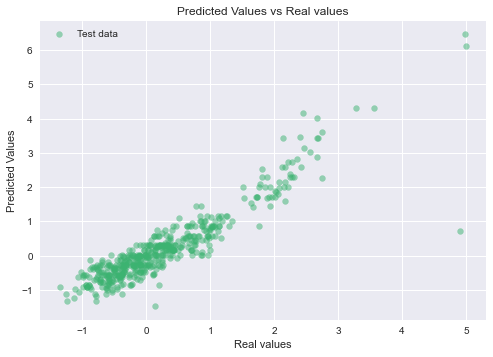

In [55]:
plt.style.use('seaborn')
plt.scatter(y_pred, y_test, color = 'mediumseagreen', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')
plt.show()

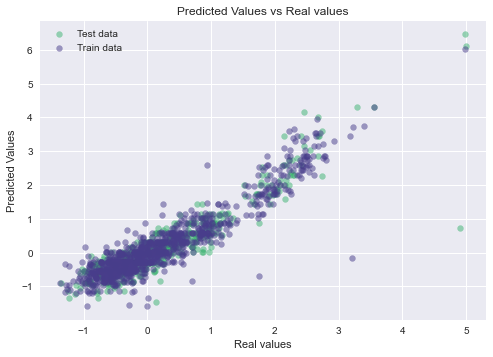

In [56]:
plt.style.use('seaborn')

y_pred1 = y_pred
y_test1 = y_test
y_pred_train1 = y_pred_train
y_train1 = y_train

plt.scatter(y_pred, y_test, color = 'mediumseagreen', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')

plt.scatter(y_pred_train, y_train, color = 'darkslateblue', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')
plt.show()

### [TEST] set

In [57]:
# TEST set
MAE_l = metrics.mean_absolute_error(y_test, y_pred)
MSE_l = metrics.mean_squared_error(y_test, y_pred)
RMSE_l = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2_l = r2_score(y_test, y_pred)

print('MAE:', MAE_l)
print('MSE:', MSE_l)
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', R2_l)

MAE: 0.2784781705369523
MSE: 0.1678276011527963
RMSE: 0.41
R2 Score: 0.8459749863951227


### [TRAIN] Cross-Validation

In [58]:
from sklearn.model_selection import cross_val_score
import math

cv_reg_model = LinearRegression() #Let's initialize the method 
cv_scores = cross_val_score(cv_reg_model, X_train, y_train,
                            cv=10, scoring='r2') # Let's define the K and the 

print('Cross Validation R2_score: {}'.format(cv_scores.round(2)))

cv_scores = np.mean(cv_scores).round(3)
print("\nAverage 10-Fold CV R2_score: {}".format(cv_scores))

Cross Validation R2_score: [0.84 0.88 0.88 0.87 0.93 0.8  0.88 0.85 0.51 0.87]

Average 10-Fold CV R2_score: 0.832


In [59]:
# Let's calculate the metrics with our TRAIN dataset
y_predTrain = regressor.predict(X_train)

MAE_lTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_lTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_lTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_lTrain = r2_score(y_train, y_predTrain)

print('\n TRAIN metrics\n')
print('MAE:', round(MAE_lTrain,3))
print('MSE:', round(MSE_lTrain,3))
print('RMSE:', round(RMSE_lTrain,3))
print('R2 Score:', round(R2_lTrain,3))

print('\n CV- TRAIN metrics\n')
print('R2 Score:', cv_scores)

print('\n TEST metrics\n')
print('MAE:', round(MAE_l,3))
print('MSE:', round(MSE_l,3))
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', round(R2_l,3))


 TRAIN metrics

MAE: 0.272
MSE: 0.144
RMSE: 0.38
R2 Score: 0.865

 CV- TRAIN metrics

R2 Score: 0.832

 TEST metrics

MAE: 0.278
MSE: 0.168
RMSE: 0.41
R2 Score: 0.846


### **Polynomial Regression - 2nd degree**

In [60]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_poly, y_train)

LinearRegression()

In [61]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score the Test set results
cv_poly2 = cross_val_score(estimator = regressor_poly2, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

# Predicting R2 Score the Test set results
y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

# Predicting RMSE the Test set results
rmse_poly2 = (np.sqrt(mean_squared_error(y_test, y_pred_poly2_test)))
print('CV: ', cv_poly2.mean())
print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE: ", rmse_poly2)

CV:  0.8315205825409355
R2_score (train):  0.9151778477369423
R2_score (test):  0.7969127708634229
RMSE:  0.47041089609853093


In [62]:
X

,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1431,0.307692,-0.973302,-1.5,-1.000000,1,0,0,1,1,0
1432,0.423077,-1.008377,-1.5,-1.222222,1,0,0,1,0,0
1433,0.384615,-1.053446,-1.5,-1.222222,1,0,0,1,0,0
1434,0.346154,-1.055718,-1.5,-1.222222,1,0,0,1,1,0


In [63]:
poly_reg = PolynomialFeatures(degree =2)

X_poly = poly_reg.fit_transform(X)
X_poly.shape

(1436, 66)

## Split data into train and test set

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [65]:
lin_reg_2 = LinearRegression()

lin_reg_2.fit(X_train, y_train)

LinearRegression()

## Step 5: Evaluate the model
### Check the accuracy

In [66]:
accuracy = lin_reg_2.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

Accuracy = 0.7987527172638684


In [67]:
y_pred = lin_reg_2.predict(X_test)
y_pred

array([ 1.99124822e-01, -2.48366006e-01, -2.24152962e-02, -3.07420911e-01,
        1.45419276e-02, -5.12054362e-01, -3.17515938e-01, -5.11687137e-01,
        1.02134877e+00,  7.97592530e-01, -8.87873308e-02, -2.12483399e-01,
        7.23297017e-01,  6.51111277e-01, -2.24413296e-02, -3.52025338e-01,
        4.57062356e-01,  2.27715616e+00, -5.65521356e-01, -2.74681225e-01,
        6.94575920e-01,  2.53719826e+00, -5.67095577e-01,  6.98222347e-02,
       -4.32084933e-01,  1.89526250e+00,  6.57647879e-02, -5.78909760e-01,
        1.68221231e+00,  1.15345736e+00, -4.46181221e-01, -2.45382775e-01,
       -4.20385301e-01,  4.29495569e-02,  6.85154170e-02, -4.86490260e-01,
       -3.06920173e-01, -1.43162470e-02,  1.91237487e+00, -1.98945712e-01,
       -5.83580739e-02, -1.37397644e-01, -5.59565056e-01, -9.47463780e-01,
       -6.04536892e-01,  2.46545027e+00, -1.29705657e-01,  1.40780864e-01,
       -2.49469844e-01,  8.82442986e-01,  8.10919251e-01, -7.10267832e-01,
        1.51868679e+00,  

In [68]:
y_pred_train = lin_reg_2.predict(X_train)
y_pred_train

array([ 0.46954545, -0.04382758,  0.31503798, ..., -0.56898367,
       -0.31477313, -0.78987598])

### Visualization of the predicted values vs real values

In [69]:
##Comparing the actual output values with the predicted values
new_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
new_df

,Actual,Predicted
594,0.257143,0.199125
754,0.014286,-0.248366
630,-0.685714,-0.022415
1259,-0.185714,-0.307421
903,-0.042857,0.014542
...,...,...
560,0.300000,0.234923
156,2.742857,2.496389
618,-0.414286,-0.311964
934,-0.271429,-0.341995


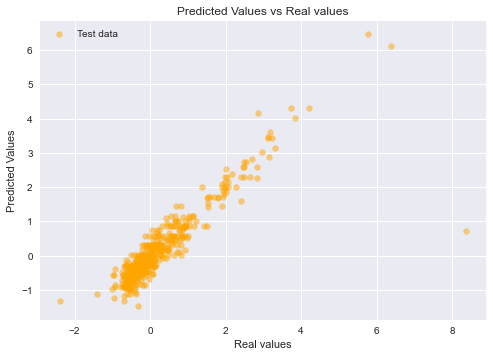

In [70]:
plt.style.use('seaborn')
plt.scatter(y_pred, y_test, color = 'orange', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')
plt.show()

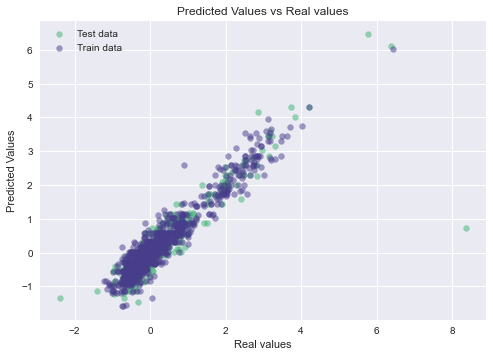

In [71]:
plt.style.use('seaborn')
plt.scatter(y_pred, y_test, color = 'mediumseagreen', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')

plt.scatter(y_pred_train, y_train, color = 'darkslateblue', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')
plt.show()

In [72]:
new_df[new_df['Predicted'] > 8]

,Actual,Predicted
221,0.728571,8.364719


In [73]:
data.iloc[221]

Price        12450
Age             44
KM           74172
HP             110
MetColor         1
Automatic        0
CC            1600
Doors            5
Weight        1615
Name: 221, dtype: int64

In [74]:
data.Age.max()

80

### [TEST]

In [75]:
# TEST set
MAE_l = metrics.mean_absolute_error(y_test, y_pred)
MSE_l = metrics.mean_squared_error(y_test, y_pred)
RMSE_l = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('MAE:', MAE_l)
print('MSE:', MSE_l)
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', accuracy)

MAE: 0.2540415306844598
MSE: 0.22871780326928384
RMSE: 0.478
R2 Score: 0.7987527172638684


### [TRAIN] Cross-Validation

In [76]:
from sklearn.model_selection import cross_val_score
import math

cv_reg_model = LinearRegression() #Let's initialize the method 
cv_scores = cross_val_score(cv_reg_model, X_train, y_train,
                            cv=10, scoring='r2') # Let's define the K and the 

print('Cross Validation R2_score: {}'.format(cv_scores.round(2)))

cv_scores = np.mean(cv_scores).round(3)
print("\nAverage 10-Fold CV R2_score: {}".format(cv_scores))

Cross Validation R2_score: [0.89 0.9  0.89 0.84 0.93 0.85 0.89 0.9  0.85 0.92]

Average 10-Fold CV R2_score: 0.886


In [77]:
# Let's calculate the metrics with our TRAIN dataset
y_predTrain = lin_reg_2.predict(X_train)

MAE_lTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_lTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_lTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_lTrain = r2_score(y_train, y_predTrain)

print('\n TRAIN metrics\n')
print('MAE:', round(MAE_lTrain,3))
print('MSE:', round(MSE_lTrain,3))
print('RMSE:', round(RMSE_lTrain,3))
print('R2 Score:', round(R2_lTrain,3))


print('-----------------------------------------------------')

print('\n CV- TRAIN metrics\n')
print('R2 Score:', cv_scores)
print('-----------------------------------------------------')

print('\n TEST metrics\n')
print('MAE:', round(MAE_l,3))
print('MSE:', round(MSE_l,3))
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', round(accuracy,3))


 TRAIN metrics

MAE: 0.229
MSE: 0.09
RMSE: 0.3
R2 Score: 0.914
-----------------------------------------------------

 CV- TRAIN metrics

R2 Score: 0.886
-----------------------------------------------------

 TEST metrics

MAE: 0.254
MSE: 0.229
RMSE: 0.478
R2 Score: 0.799


In [78]:
data_scaled

,Price,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,1.028571,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,1.100000,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,1.157143,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,1.442857,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,1.100000,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1431,-0.685714,0.307692,-0.973302,-1.5,-1.000000,1,0,0,1,1,0
1432,0.270000,0.423077,-1.008377,-1.5,-1.222222,1,0,0,1,0,0
1433,-0.400000,0.384615,-1.053446,-1.5,-1.222222,1,0,0,1,0,0
1434,-0.757143,0.346154,-1.055718,-1.5,-1.222222,1,0,0,1,1,0


In [79]:
data2 = data['Price'] > 30000

In [80]:
data['KM'].describe()

count      1436.000000
mean      68533.259749
std       37506.448872
min           1.000000
25%       43000.000000
50%       63389.500000
75%       87020.750000
max      243000.000000
Name: KM, dtype: float64

In [81]:
data[data['KM'] == 1]

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
109,32500,4,1,116,0,0,2000,5,1480
117,17900,7,1,110,1,0,1600,3,1105
169,17795,9,1,98,1,0,1400,4,1065
170,18245,9,1,110,1,0,1600,5,1075
184,17795,1,1,98,1,0,1400,4,1100
185,18245,1,1,110,1,0,1600,5,1075
601,7500,50,1,90,1,0,2000,3,1260
1435,6950,76,1,110,0,0,1600,5,1114


In [82]:
data[data['Age'] > 50]

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
378,6500,53,216000,69,0,0,1900,3,1110
379,6400,51,198167,69,0,0,1900,4,1095
380,7000,53,176000,69,0,0,1900,3,1105
381,7750,54,174139,72,1,0,2000,4,1100
383,8500,55,150000,110,1,0,1600,3,1075
...,...,...,...,...,...,...,...,...,...
1431,7500,69,20544,86,1,0,1300,3,1025
1432,10845,72,19000,86,0,0,1300,3,1015
1433,8500,71,17016,86,0,0,1300,3,1015
1434,7250,70,16916,86,1,0,1300,3,1015


In [83]:
data.MetColor.value_counts()

1    969
0    467
Name: MetColor, dtype: int64

In [84]:
data[data['Price'] > 30000]

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
109,32500,4,1,116,0,0,2000,5,1480
110,31000,4,4000,116,1,0,2000,5,1480
111,31275,4,1500,116,1,0,2000,5,1480


### Drop outliers

In [85]:
data_scaled2 = data_scaled.drop(index=[109,110,111])

In [86]:
data_scaled2.head()

,Price,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,1.028571,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,1.100000,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,1.157143,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,1.442857,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,1.100000,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0


In [87]:
data_scaled2.shape

(1433, 11)

In [88]:
X = data_scaled2.drop(['Price'], axis = 1)
y = data_scaled2['Price']

X

,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1431,0.307692,-0.973302,-1.5,-1.000000,1,0,0,1,1,0
1432,0.423077,-1.008377,-1.5,-1.222222,1,0,0,1,0,0
1433,0.384615,-1.053446,-1.5,-1.222222,1,0,0,1,0,0
1434,0.346154,-1.055718,-1.5,-1.222222,1,0,0,1,1,0


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.33, 
                                                    random_state = 42)

In [90]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [91]:
y_pred = regressor.predict(X_test)
y_pred

array([ 1.38916944e+00,  5.31478065e-01,  2.65499712e-01,  4.57011902e-01,
       -1.15336436e-01,  9.84546319e-01,  9.26344401e-01,  1.50399798e+00,
        2.66816911e-02, -8.87274977e-02, -3.36020607e-01, -3.79073767e-01,
        1.30710899e-01,  2.18203074e+00,  5.63895988e-01,  1.20700024e-01,
       -7.47009101e-01,  7.80695030e-01, -3.76376427e-01,  1.24542248e-01,
        8.72012937e-01,  2.60422235e-01, -1.03872876e+00,  2.61824476e-01,
       -3.51649707e-01,  1.70271978e+00, -6.51574665e-01,  2.75560442e-01,
        1.27796674e-01, -7.41918506e-02,  2.12812942e-01,  1.77111888e+00,
       -3.51814149e-01, -5.93164396e-01, -5.19515537e-01,  3.01948579e-01,
        4.28428518e-01,  5.89141474e-01, -1.73112053e-01,  2.49358186e+00,
       -3.37214828e-01, -7.95439181e-01, -3.77140035e-01,  1.51778836e-01,
       -8.74125274e-01,  5.23572520e-01, -6.57531201e-01,  4.29197457e-01,
       -8.19388136e-01, -1.26000884e-01,  6.08894893e-01,  1.90437138e+00,
       -4.20819361e-01, -

In [92]:
y_pred_train = regressor.predict(X_train)
y_pred_train

array([-3.75303131e-01, -4.05940457e-01, -1.39412559e-01,  7.84739300e-01,
        1.07101397e+00,  8.27904313e-01,  7.14541353e-01,  1.77876339e+00,
        2.02105377e-01,  4.05265031e-01, -5.88676746e-01, -1.11976465e+00,
       -2.12658619e-01,  3.85590900e-01,  1.02849897e-01, -1.30458541e-01,
       -5.56631231e-01, -4.01609012e-01,  9.30070656e-02, -2.10177595e-01,
        1.27685219e+00,  4.96506174e-01,  1.82026409e-01, -8.48019645e-01,
       -7.90148609e-01,  9.54678305e-02,  6.17225973e-02, -2.33005518e-01,
       -1.18556338e+00, -6.93913383e-01,  3.82649562e-02, -6.45314255e-01,
       -5.31784198e-01,  6.91673036e-02,  1.70654028e-01,  1.72670230e-01,
       -6.40065424e-01,  1.23727961e+00,  2.19872743e+00,  1.14748847e+00,
       -8.05523116e-01, -1.79417753e-01,  2.52870880e+00,  2.68368341e+00,
        9.41095997e-01, -5.56147689e-01, -4.93054608e-01, -9.90828862e-02,
        2.71057295e+00, -2.69545560e-01, -4.41584791e-01, -5.22487256e-01,
        2.45488318e+00, -

In [93]:
regressor.coef_

array([-9.10364683e-01, -2.03199254e-01,  3.33893988e-02,  3.54736005e-01,
       -3.79183968e-02, -6.19799091e-02, -2.92467821e-01,  3.54447731e-01,
       -8.74164555e-04,  8.35059743e-02])

In [94]:
accuracy = regressor.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

Accuracy = 0.8137028246323292


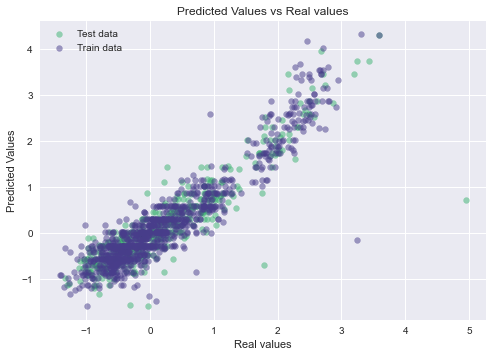

In [95]:
plt.style.use('seaborn')
plt.scatter(y_pred, y_test, color = 'mediumseagreen', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')

plt.scatter(y_pred_train, y_train, color = 'darkslateblue', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')
plt.show()

In [96]:
# TEST set
MAE_l = metrics.mean_absolute_error(y_test, y_pred)
MSE_l = metrics.mean_squared_error(y_test, y_pred)
RMSE_l = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2_l = r2_score(y_test, y_pred)

print('MAE:', MAE_l)
print('MSE:', MSE_l)
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', R2_l)

MAE: 0.2739635266677455
MSE: 0.1685889312633943
RMSE: 0.411
R2 Score: 0.8137028246323292


In [97]:
# Cross validation
from sklearn.model_selection import cross_val_score
import math

cv_reg_model = LinearRegression() #Let's initialize the method 
cv_scores = cross_val_score(cv_reg_model, X_train, y_train,
                            cv=10, scoring='r2') # Let's define the K and the 

print('Cross Validation R2_score: {}'.format(cv_scores.round(2)))

cv_scores = np.mean(cv_scores).round(3)
print("\nAverage 10-Fold CV R2_score: {}".format(cv_scores))

Cross Validation R2_score: [0.82 0.89 0.87 0.88 0.92 0.87 0.87 0.9  0.82 0.65]

Average 10-Fold CV R2_score: 0.848


In [98]:
# Let's calculate the metrics with our TRAIN dataset
y_predTrain = regressor.predict(X_train)

MAE_lTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_lTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_lTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_lTrain = r2_score(y_train, y_predTrain)

print('\n TRAIN metrics\n')
print('MAE:', round(MAE_lTrain,3))
print('MSE:', round(MSE_lTrain,3))
print('RMSE:', round(RMSE_lTrain,3))
print('R2 Score:', round(R2_lTrain,3))

print('\n CV- TRAIN metrics\n')
print('R2 Score:', cv_scores)

print('\n TEST metrics\n')
print('MAE:', round(MAE_l,3))
print('MSE:', round(MSE_l,3))
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', round(R2_l,3))


 TRAIN metrics

MAE: 0.274
MSE: 0.141
RMSE: 0.375
R2 Score: 0.866

 CV- TRAIN metrics

R2 Score: 0.848

 TEST metrics

MAE: 0.274
MSE: 0.169
RMSE: 0.411
R2 Score: 0.814


### Comparison Multivariate Linear Regression scatter plots with/without outliers

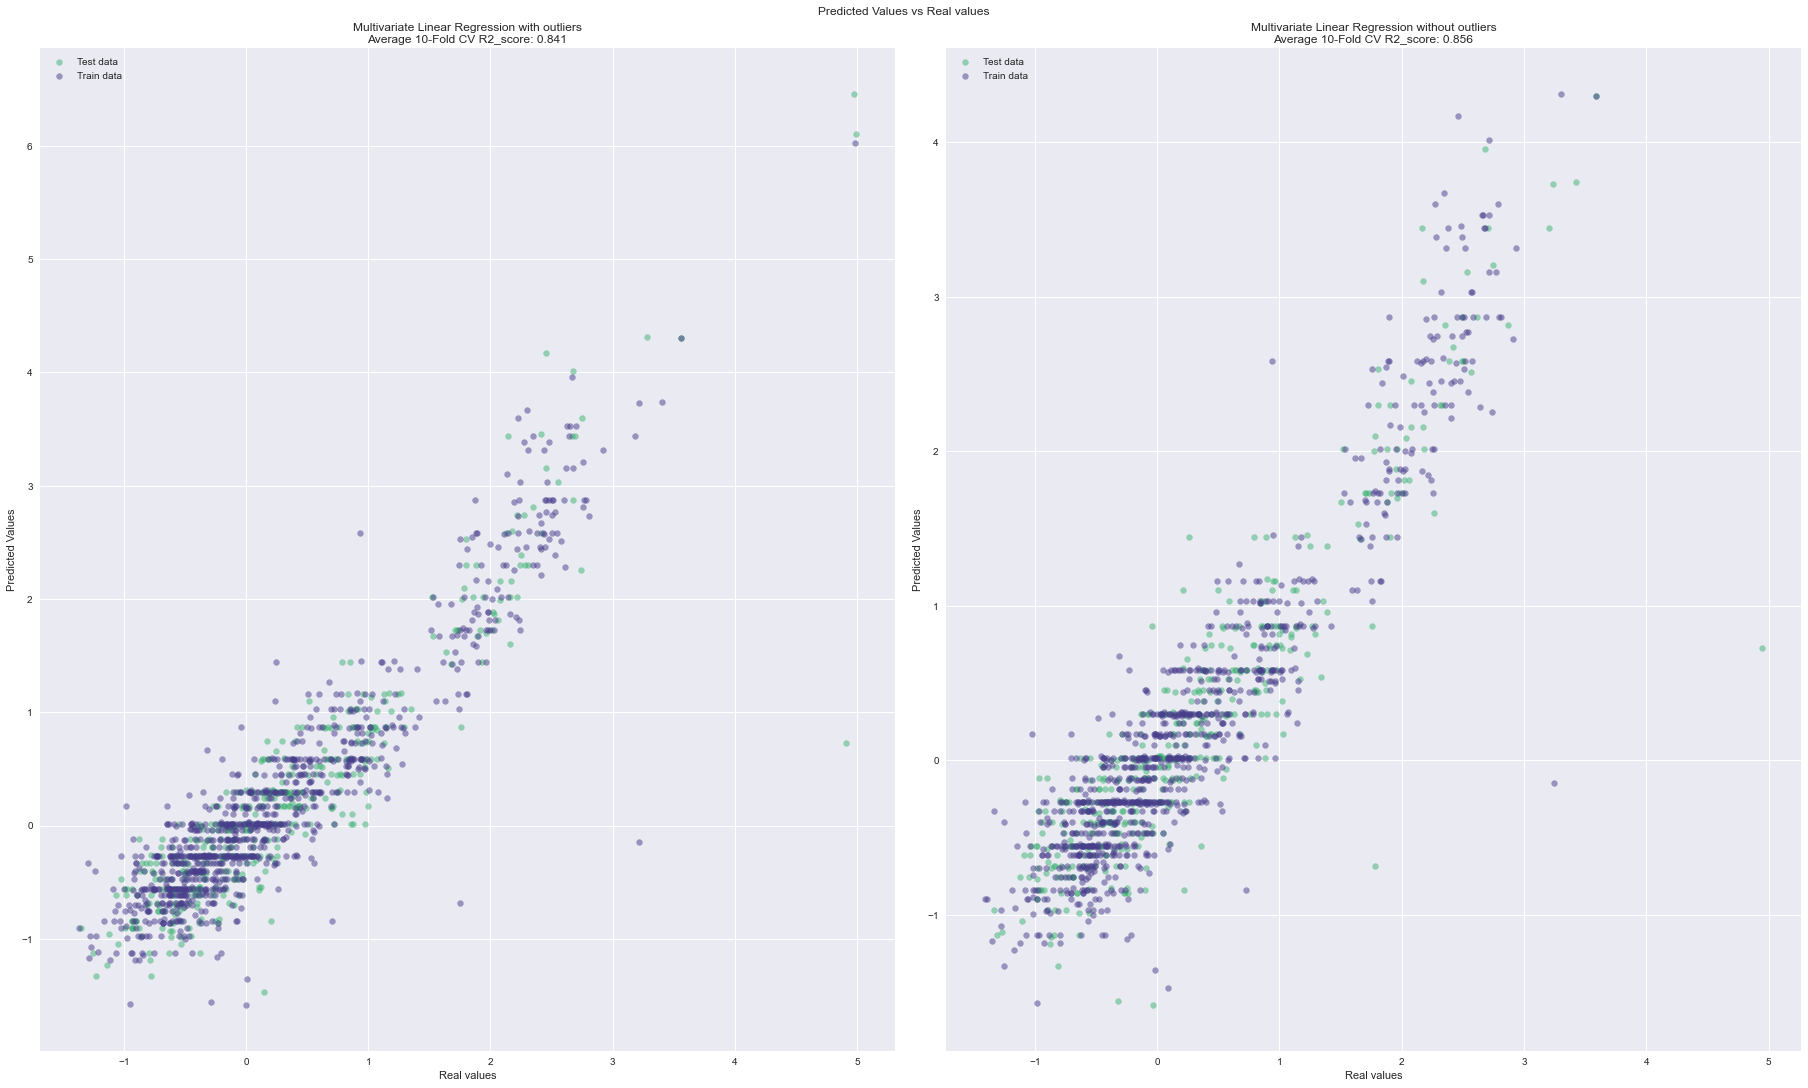

In [99]:
plt.style.use('seaborn')
fig = plt.figure(constrained_layout=True, figsize=(25,15))

ax1 = fig.add_subplot(1,2,1)
ax1 = plt.scatter(y_pred1, y_test1, color = 'mediumseagreen', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')
ax1 = plt.scatter(y_pred_train1, y_train1, color = 'darkslateblue', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.title('Multivariate Linear Regression with outliers\nAverage 10-Fold CV R2_score: 0.841')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')

ax2 = fig.add_subplot(1,2,2)
ax2 = plt.scatter(y_pred, y_test, color = 'mediumseagreen', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')
ax2 = plt.scatter(y_pred_train, y_train, color = 'darkslateblue', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.title('Multivariate Linear Regression without outliers\nAverage 10-Fold CV R2_score: 0.856')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')

plt.suptitle('Predicted Values vs Real values')

plt.show()

# Prepare the data for the model building
## Let's scale the X with `StandardScaler`

In [100]:
X

,Age,KM,CC,Weight,Doors,['FuelType']_CNG,['FuelType']_Diesel,['FuelType']_Petrol,MetColor,Automatic
0,-1.461538,-0.372631,2.0,2.111111,1,0,1,0,1,0
1,-1.461538,0.216886,2.0,2.111111,1,0,1,0,1,0
2,-1.423077,-0.492461,2.0,2.111111,1,0,1,0,1,0
3,-1.346154,-0.349596,2.0,2.111111,1,0,1,0,0,0
4,-1.192308,-0.565404,2.0,2.222222,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1431,0.307692,-0.973302,-1.5,-1.000000,1,0,0,1,1,0
1432,0.423077,-1.008377,-1.5,-1.222222,1,0,0,1,0,0
1433,0.384615,-1.053446,-1.5,-1.222222,1,0,0,1,0,0
1434,0.346154,-1.055718,-1.5,-1.222222,1,0,0,1,1,0


In [101]:
# Initialise the Scaler 
scaler = StandardScaler() 
  
# Scale data 
X_c = scaler.fit_transform(X)

## Train-test split

In [102]:
X_c

array([[-1.79064782, -0.57973958,  2.33050857, ..., -2.73482905,
         0.69419219, -0.24316222],
       [-1.79064782,  0.1139891 ,  2.33050857, ..., -2.73482905,
         0.69419219, -0.24316222],
       [-1.73647741, -0.72075221,  2.33050857, ..., -2.73482905,
         0.69419219, -0.24316222],
       ...,
       [ 0.80953204, -1.38090519, -1.42769337, ...,  0.36565357,
        -1.44052327, -0.24316222],
       [ 0.75536162, -1.38357842, -1.42769337, ...,  0.36565357,
         0.69419219, -0.24316222],
       [ 1.08038411, -1.83575447,  0.1829646 , ...,  0.36565357,
        -1.44052327, -0.24316222]])

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

# Model 1: Ridge Regression

In [104]:
# Create ridge regression with three possible alpha values
regr_cv = RidgeCV()
regr_cv

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [105]:
# Fit the linear regression
model_cv = regr_cv.fit(X_train, y_train)
model_cv

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [106]:
#View Best Model’s Alpha Value
model_cv.alpha_

10.0

In [107]:
rr_ = Ridge(alpha = model_cv.alpha_)
# higher the alpha value, more restriction on the coefficients; 
# low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles

rr_.fit(X_train, y_train)

Ridge(alpha=10.0)

In [108]:
# Execute this line (of course, modifying the path)
import sys
sys.path.insert(0, '../_functions_/')

In [109]:
from fx_MLRegression import *

In [110]:
metrics_train(X_train, y_train, rr_)

,MAE,MSE,RMSE,R2,CV_R2
Train,0.270801,0.138524,0.372189,0.865031,0.849


In [111]:
metrics_test(X_test, y_test, rr_)

,MAE,MSE,RMSE,R2,CV_R2
Test,0.277487,0.175069,0.418413,0.813972,0.765


In [112]:
rr_metrics = Allmetrics(rr_, X_train, y_train, X_test, y_test)
rr_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.270801,0.138524,0.372189,0.865031,0.849
Test,0.277487,0.175069,0.418413,0.813972,0.765


In [113]:
# Visualitzation of the model performance
y_predRR = rr_.predict(X_test)
y_predRR

array([ 1.38174838,  0.52389507,  0.26350397,  0.45861492, -0.11038127,
        0.97575089,  0.91843762,  1.48797478,  0.02015239, -0.08514493,
       -0.33340413, -0.3737356 ,  0.12933002,  2.14627634,  0.5534315 ,
        0.12193879, -0.73892399,  0.76540495, -0.39536633,  0.11872475,
        0.87261516,  0.25942151, -1.02801858,  0.26535543, -0.34054343,
        1.68928851, -0.64716931,  0.27455483,  0.12825632, -0.07152646,
        0.21326717,  1.75562316, -0.35057023, -0.58788355, -0.51470812,
        0.2874253 ,  0.42137421,  0.57626957, -0.17443115,  2.47097175,
       -0.33848379, -0.79131368, -0.3748761 ,  0.13423874, -0.88459746,
        0.53159214, -0.65789909,  0.43220476, -0.81535614, -0.12576221,
        0.60798889,  1.88952003, -0.4156527 , -0.0232415 , -0.54899515,
        1.89029393,  2.14140306,  1.11422604, -0.06817742,  1.08548141,
        0.37295027, -0.43728246, -0.70093914,  1.79131094,  0.71282017,
        0.37156042, -0.65162757,  1.1325585 ,  2.0432601 ,  0.32

In [114]:
#Let's create a dataframe containing the real and predicted values_
y_pred_rr = pd.DataFrame(y_predRR)
y_pred_rr

,0
0,1.381748
1,0.523895
2,0.263504
3,0.458615
4,-0.110381
...,...
425,2.852393
426,0.642722
427,-0.239953
428,0.346401


In [115]:
y_test_rr = y_test.reset_index(drop=True, inplace=False)
y_test_rr

0      0.957143
1      0.871429
2     -0.114286
3      0.014286
4     -0.471429
         ...   
425    2.814286
426    0.517143
427   -0.828857
428    0.528571
429   -0.271429
Name: Price, Length: 430, dtype: float64

In [116]:
# We create a new dataframe containing both the real (y_test) and the predicted value by the model (y_pred)
pred_act_rr_df = pd.concat([y_test_rr,y_pred_rr], axis=1)
pred_act_rr_df

,Price,0
0,0.957143,1.381748
1,0.871429,0.523895
2,-0.114286,0.263504
3,0.014286,0.458615
4,-0.471429,-0.110381
...,...,...
425,2.814286,2.852393
426,0.517143,0.642722
427,-0.828857,-0.239953
428,0.528571,0.346401


In [117]:
pred_act_rr_df.rename({'Price': 'Real', 0: 'Predicted'}, axis=1, inplace=True)
pred_act_rr_df

,Real,Predicted
0,0.957143,1.381748
1,0.871429,0.523895
2,-0.114286,0.263504
3,0.014286,0.458615
4,-0.471429,-0.110381
...,...,...
425,2.814286,2.852393
426,0.517143,0.642722
427,-0.828857,-0.239953
428,0.528571,0.346401


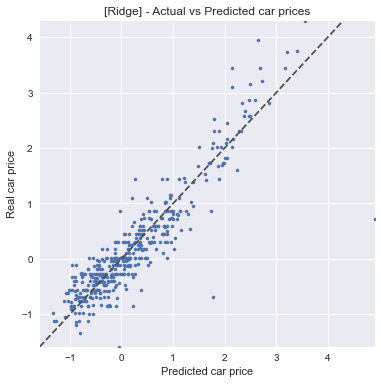

In [118]:
# Let's represent the preducted values vs the real values
plt.figure(figsize=(6, 6))

#Limits
maxlimit_rr = pred_act_rr_df['Real'].max()
minlimit_rr = pred_act_rr_df['Real'].min()
plt.xlim(-1, maxlimit_rr)
plt.ylim(-1, maxlimit_rr)

plt.scatter(pred_act_rr_df['Predicted'], 
            pred_act_rr_df['Real'], s=10)
plt.xlabel('Predicted car price')
plt.ylabel('Real car price')

plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.plot([minlimit_rr,maxlimit_rr], [minlimit_rr,maxlimit_rr], ls="--", c=".3")
plt.title('[Ridge] - Actual vs Predicted car prices')
plt.show()

# Model 2: Lasso Regression

In [119]:
clf_la = Lasso(alpha=0.0001) #alpha=1.0 by default
clf_la
clf_la.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [120]:
# Visualitzation of the model performance
y_predLA = clf_la.predict(X_test)

# Let's create a dataframe containing the real and predicted values_
y_pred_la = pd.DataFrame(y_predLA)
y_test_la = y_test.reset_index(drop=True, inplace=False)

# We create a new dataframe containing both the real (y_test) and the predicted value by the model (y_pred)
pred_act_la_df = pd.concat([y_test_la,y_pred_la], axis=1)

In [121]:
pred_act_la_df.rename({'Price': 'Real', 0: 'Predicted'}, 
                   axis=1, inplace=True)
pred_act_la_df

,Real,Predicted
0,0.957143,1.385791
1,0.871429,0.525062
2,-0.114286,0.258265
3,0.014286,0.456240
4,-0.471429,-0.118728
...,...,...
425,2.814286,2.872299
426,0.517143,0.644577
427,-0.828857,-0.246972
428,0.528571,0.347967


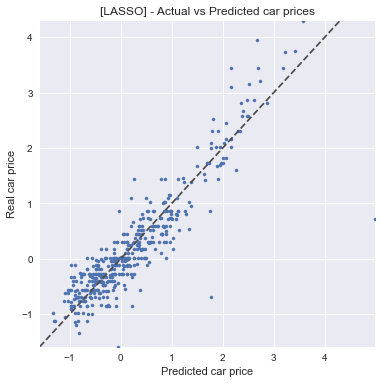

In [122]:
# Let's represent the preducted values vs the real House value
plt.figure(figsize=(6, 6))

#Limits
maxlimit = pred_act_la_df['Real'].max()
minlimit = pred_act_la_df['Real'].min()
plt.xlim(-1, maxlimit)
plt.ylim(-1, maxlimit)

plt.scatter(pred_act_la_df['Predicted'], 
            pred_act_la_df['Real'], s=10)
plt.xlabel('Predicted car price')
plt.ylabel('Real car price')

plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.plot([minlimit,maxlimit], [minlimit,maxlimit], ls="--", c=".3")
plt.title('[LASSO] - Actual vs Predicted car prices')
plt.show()

In [123]:
lasso_metrics = Allmetrics(clf_la, X_train, y_train, X_test, y_test)
lasso_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.271092,0.138459,0.372101,0.865095,0.848
Test,0.278200,0.176606,0.420246,0.812339,0.753


In [124]:
rr_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.270801,0.138524,0.372189,0.865031,0.849
Test,0.277487,0.175069,0.418413,0.813972,0.765


## Visualizing R2-Score of Algorithms

In [125]:
rr_metrics.loc['Train','R2']

0.8650310703050842

In [126]:
lasso_metrics.loc['Train','R2']

0.8650945490483075

In [127]:
models = ['Ridge', 'Lasso']
R2_Scores = [rr_metrics.loc['Train','R2'], lasso_metrics.loc['Train','R2']]
R2_Scores

[0.8650310703050842, 0.8650945490483075]

In [128]:
compare = pd.DataFrame({'Algorithms' : models , 'R2-Scores' : R2_Scores})
compare.sort_values(by='R2-Scores' ,ascending=False)

,Algorithms,R2-Scores
1,Lasso,0.865095
0,Ridge,0.865031


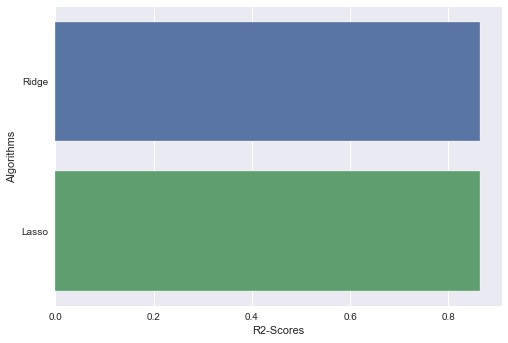

In [129]:
sns.barplot(x='R2-Scores' , y='Algorithms' , data=compare);

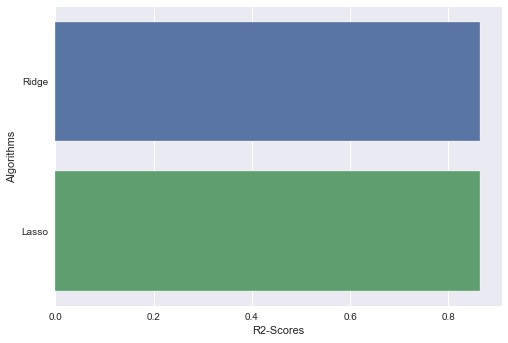

In [130]:
R2_Scores = [rr_metrics.loc['Test','R2'], lasso_metrics.loc['Test','R2']]
sns.barplot(x='R2-Scores' , y='Algorithms' , data=compare);

# Model 3: Ridge after log_transformation on the target variable

In [131]:
data_log = dataset.copy()

In [132]:
data_log['Price_log'] = np.log(data_log['Price'])

In [133]:
data_log.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,Price_log
0,13500,23,46986,Diesel,90,1,0,2000,3,1165,9.510445
1,13750,23,72937,Diesel,90,1,0,2000,3,1165,9.528794
2,13950,24,41711,Diesel,90,1,0,2000,3,1165,9.543235
3,14950,26,48000,Diesel,90,0,0,2000,3,1165,9.612467
4,13750,30,38500,Diesel,90,0,0,2000,3,1170,9.528794


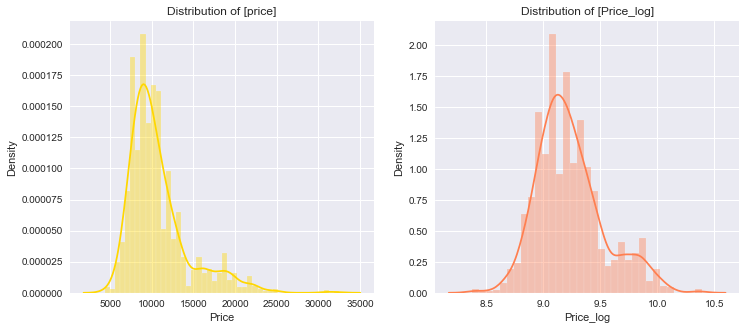

In [134]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
sns.distplot(data_log['Price'],color='gold',ax=ax)
ax.set_title('Distribution of [price]')

ax=f.add_subplot(122)
sns.distplot(data_log['Price_log'],color='coral',ax=ax)
ax.set_title('Distribution of [Price_log]');

In [135]:
data_log["Price_log"].std()

0.2962261744640541

In [136]:
data_log["Price"].std()

3626.9645849102394

## Define target and non-target variables

In [137]:
X = data_log.drop(['Price_log','Price', 'FuelType'], axis=1)
y = data_log['Price_log']

## Let's scale the X with `StandardScaler`

In [138]:
# Initialise the Scaler 
scaler = StandardScaler() 
  
# Scale data 
X_c = scaler.fit_transform(X)

## Train-test split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_c,y,test_size=0.3,
                                                    random_state=42)

## Model building

In [140]:
# Create ridge regression with three possible alpha values
regr_cv = RidgeCV(alphas=[0.1,0.5, 1.0, 10.0])
regr_cv

RidgeCV(alphas=array([ 0.1,  0.5,  1. , 10. ]))

In [141]:
# Fit the linear regression
model_cv = regr_cv.fit(X_train, y_train)
model_cv

RidgeCV(alphas=array([ 0.1,  0.5,  1. , 10. ]))

In [142]:
#View Best Model’s Alpha Value
model_cv.alpha_

10.0

In [143]:
regr_cv = RidgeCV(alphas=[1,2,5, 10,12])

In [144]:
# Fit the linear regression
model_cv = regr_cv.fit(X_train, y_train)

#View Best Model’s Alpha Value
model_cv.alpha_

12

In [145]:
rr2_ = Ridge(alpha = model_cv.alpha_)# higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles

rr2_.fit(X_train, y_train)

Ridge(alpha=12)

## Evaluate the model

In [146]:
log_metrics = Allmetrics(rr2_, X_train, y_train, X_test, y_test)
log_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.086241,0.013593,0.116590,0.843653,0.83
Test,0.083786,0.013116,0.114527,0.853327,0.84


In [147]:
y.describe()[['min', 'max']]

min     8.377931
max    10.388995
Name: Price_log, dtype: float64

In [148]:
data_log.Price.describe()[['min', 'max']]

min     4350.0
max    32500.0
Name: Price, dtype: float64

## Reverse the transformation

In [149]:
y_predtest = rr2_.predict(X_test)
y_predtest

array([ 9.3138169 ,  9.08803599,  9.08366356,  9.0956512 ,  9.18216938,
        8.99145804,  9.0874593 ,  9.04096358,  9.52726638,  9.44699336,
        9.12013139,  9.12509299,  9.43290918,  9.45358502,  9.15592891,
        9.06506197,  9.3959224 ,  9.69175102,  8.94974618,  9.11627088,
        9.41205824,  9.821109  ,  8.99203912,  9.23567107,  8.99326656,
        9.66590593,  9.18591861,  8.94641818,  9.63865111,  9.56718265,
        9.02330002,  9.19262138,  9.05956133,  9.19063398,  9.20618809,
        9.01135736,  9.10072333,  9.16991631,  9.69728101,  9.1256549 ,
        9.17289219,  9.14368685,  9.00445324,  8.80647376,  8.93986976,
        9.74640191,  9.13442654,  9.23837135,  9.09723614,  9.47916313,
        9.42891591,  8.90275957,  9.57051753,  9.66903559,  8.86565401,
        8.99064628,  9.2224854 ,  9.21287255,  9.65894922,  9.85201948,
        9.38736662,  8.97542285,  8.99791891,  9.28455197,  9.46842685,
        9.08736935,  9.40978021,  8.96776914,  9.02850525,  9.25

In [150]:
y_predtest.min()

8.738325928923674

In [151]:
y_predtest.max()

10.382942078560847

In [152]:
# We are going to use the np.exp() method
y_predtest = np.exp(y_predtest)

In [153]:
y_predtest

array([11090.19762831,  8848.78985889,  8810.18360607,  8916.43245979,
        9722.22106313,  8034.16249004,  8843.68830559,  8441.90758332,
       13729.00988028, 12670.01372049,  9137.40213456,  9182.85092723,
       12492.8177898 , 12753.80602634,  9470.42358608,  8647.81505847,
       12039.18953545, 16183.5571897 ,  7705.93567508,  9102.19505889,
       12235.02773334, 18418.46541056,  8038.83231897, 10256.54242606,
        8048.70562021, 15770.65053823,  9758.74040971,  7680.33295837,
       15346.62887124, 14288.10496482,  8294.10266133,  9824.37070701,
        8600.3770798 ,  9804.86510823,  9958.56331023,  8195.63817622,
        8961.77269833,  9603.82092912, 16273.29998464,  9188.01226401,
        9632.44331497,  9355.19286174,  8139.24936215,  6677.33181413,
        7630.20320986, 17092.61719966,  9268.96069525, 10284.27539712,
        8930.57569318, 13084.23218764, 12443.03006636,  7352.23461314,
       14335.83368002, 15820.084592  ,  7084.42510602,  8027.64334084,
      

In [154]:
y_predtest.max()

32303.862320911187

In [155]:
y_predtest.min()

6237.445040780701

## Run Three Lasso Regressions, Varying Alpha Levels

In [156]:
# Create a function called lasso,
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()
    
    # Create a column of feature names
    df['Feature Name'] = X.columns
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        
        # Fit the lasso regression
        lasso.fit(X_train, y_train)
        
        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_
        
    # Return the datafram    
    return df


In [157]:
# Run the function called, Lasso
lasso([.0001, .001, .01, .5, 1])


,Feature Name,Alpha = 0.000100,Alpha = 0.001000,Alpha = 0.010000,Alpha = 0.500000,Alpha = 1.000000
0,Age,-0.190844,-0.190896,-0.189579,-0.0,-0.0
1,KM,-0.063452,-0.063936,-0.061618,-0.0,-0.0
2,HP,0.035842,0.034945,0.028243,0.0,0.0
3,MetColor,0.004140,0.003369,0.000000,0.0,0.0
4,Automatic,0.007282,0.006781,0.000000,0.0,0.0
5,CC,-0.010599,-0.007711,-0.000000,0.0,0.0
6,Doors,0.005667,0.005382,0.000000,0.0,0.0
7,Weight,0.062498,0.059586,0.047439,0.0,0.0


# Ridge Regression and the Lasso

We will use the sklearn package in order to perform ridge regression and the lasso. The main functions in this package that we care about are Ridge(), which can be used to fit ridge regression models, and Lasso() which will fit lasso models. They also have cross-validated counterparts: RidgeCV() and LassoCV(). We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have been removed from the data, as described in the previous lab.

## Ridge Regression

The Ridge() function has an alpha argument (λ, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [158]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll store in a matrix coefs. In this case, it is a 19×100 matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of alpha). Remember that we'll want to standardize the variables so that they are on the same scale. To do this, we can use the normalize = True parameter:

In [159]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 8)

We expect the coefficient estimates to be much smaller, in terms of l2 norm, when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

Text(0, 0.5, 'weights')

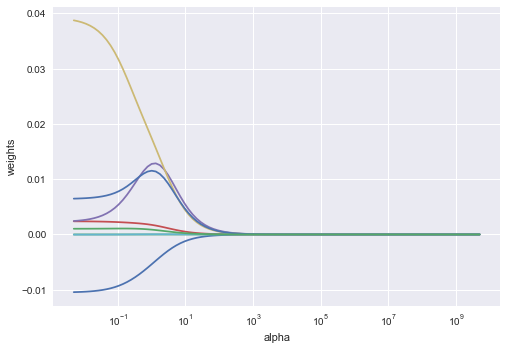

In [160]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using λ=4:

In [161]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

Age         -0.045006
KM          -0.030264
HP           0.014358
MetColor     0.005155
Automatic    0.001644
CC           0.004253
Doors        0.007455
Weight       0.025319
dtype: float64
0.04973648265792891


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say 10^10:

In [162]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

Age         -2.557835e-11
KM          -1.794080e-11
HP           9.196445e-12
MetColor     3.653020e-12
Automatic    1.013317e-12
CC           3.497690e-12
Doors        5.331581e-12
Weight       1.562734e-11
dtype: float64
0.08942870320102216


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with alpha = 4 instead of just performing least squares regression. Recall that least squares is simply ridge regression with alpha = 0.

In [163]:
ridge4 = Ridge(alpha = 0, normalize = True)
ridge4.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge4.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge4.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

Age         -0.190843
KM          -0.063395
HP           0.035942
MetColor     0.004226
Automatic    0.007338
CC          -0.010921
Doors        0.005698
Weight       0.062820
dtype: float64
0.013084345357201972


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha =4
, it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, RidgeCV(). By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument cv.

In [164]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.015269277544167062

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.062. What is the test MSE associated with this value of alpha?

In [165]:
ridge5 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge5.fit(X_train, y_train)
mean_squared_error(y_test, ridge5.predict(X_test))

0.013133529239034877

This represents a further improvement over the test MSE that we got using alpha=4. Finally, we refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, and examine the coefficient estimates.

In [166]:
ridge5.fit(X_c, y)
pd.Series(ridge5.coef_, index = X.columns)

Age         -0.191371
KM          -0.066823
HP           0.035326
MetColor     0.001308
Automatic    0.008659
CC          -0.004366
Doors        0.006305
Weight       0.054810
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not perform variable selection!

In [167]:
ridge5_metrics = Allmetrics(ridge5, X_train, y_train, X_test, y_test)
ridge5_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.086818,0.013641,0.116793,0.843109,0.83
Test,0.083534,0.012781,0.113054,0.857076,0.84


# The Lasso

We saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we'll use the Lasso() function; however, this time we'll need to include the argument max_iter = 10000. Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

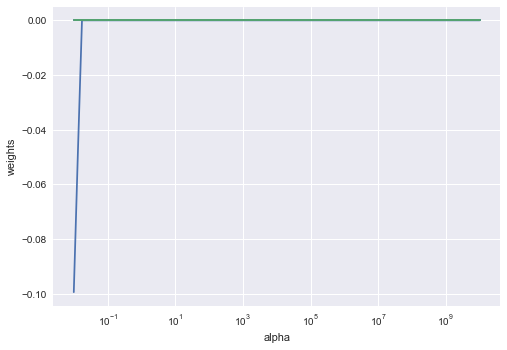

In [168]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [169]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

0.013034128833411542

This is substantially lower than the test set MSE of the null model and of least squares, and only a little worse than the test MSE of ridge regression with alpha chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 3 of the 11 coefficient estimates are exactly zero:

In [170]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

Age         -0.190834
KM          -0.063815
HP           0.035210
MetColor     0.003592
Automatic    0.006902
CC          -0.008584
Doors        0.005451
Weight       0.060523
dtype: float64

In [171]:
lassocv_metrics = Allmetrics(lasso, X_train, y_train, X_test, y_test)
lassocv_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.086347,0.013592,0.116585,0.843666,0.83
Test,0.083644,0.013034,0.114167,0.854248,0.84


In [172]:
lasso_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.271092,0.138459,0.372101,0.865095,0.848
Test,0.278200,0.176606,0.420246,0.812339,0.753


In [173]:
ridge5_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.086818,0.013641,0.116793,0.843109,0.83
Test,0.083534,0.012781,0.113054,0.857076,0.84


In [174]:
rr_metrics

,MAE,MSE,RMSE,R2,CV_R2
Train,0.270801,0.138524,0.372189,0.865031,0.849
Test,0.277487,0.175069,0.418413,0.813972,0.765
